# Measuring the Innovation Impact of an Organization using Patents Citations

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to analyze the innovation impact of an organization. 

There are **two ways** to achieve this. The **first approach counts direct links** between patents and the GRID organization we are interested in (i.e., it counts how many patents' inventors are affiliated to the GRID organization). This method is faster to implement and can be easily achieved via a single [patents API](https://docs.dimensions.ai/dsl/datasource-patents.html) query: 

```
> search patents where assignees in ["grid.89170.37"] return patents limit 500
Returned Patents: 192 
---
[1] METHODS AND SYSTEMS FOR OBJECT IDENTIFICATION AND FOR AUTHENTICATION (id: https://app.dimensions.ai/details/patent/WO-2007149621-A3 )
[2] ADENOVIRAL VECTOR-BASED MALARIA VACCINES (id: https://app.dimensions.ai/details/patent/EP-1929021-A2 )
[3] MULTIPLE BAND SHORT WAVE INFRARED MOSAIC ARRAY FILTER (id: https://app.dimensions.ai/details/patent/WO-2016040755-A1 )
[4] ARMOR PLATE (id: https://app.dimensions.ai/details/patent/WO-2011142867-A3 )
..etc..
```

The **second method counts indirect links via publications**, hence it permits to gain some insight into the *indirect* innovation impact of a research organization. 

This is the method we'll be focusing on, in this tutorial. The goal therefore is to extract and inspect patents that **cite** publications from the research organization in question.   

Since the various content-types included in the Dimensions database are [deeply interlinked](https://docs.dimensions.ai/dsl/data-sources.html), the Dimensions APIs allow to perform this analysis via a few simple steps: 

* We start from a [GRID](https://grid.ac/) identifier (representing a research organization in Dimensions) 
* We use the [publications API](https://docs.dimensions.ai/dsl/datasource-publications.html) to extract all publications where at least one author is/as affiliated to the GRID organization, for a selected time-period
* We then use the [patents API](https://docs.dimensions.ai/dsl/datasource-patents.html) to discover patents that include citations to any of those publications 
* Finally, we analyse the patents data to highlight trends e.g. about countries, inventors etc.. 


In [1]:
import datetime
print("==\nCHANGELOG\nThis notebook was last run on %s\n==" % datetime.date.today().strftime('%b %d, %Y'))

==
CHANGELOG
This notebook was last run on Jan 25, 2022
==


## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the ['Getting Started' tutorial](https://api-lab.dimensions.ai/cookbooks/1-getting-started/1-Using-the-Dimcli-library-to-query-the-API.html).

In [2]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *

import os, sys, time, json
from tqdm.notebook import tqdm as progressbar

import pandas as pd

import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

Searching config file credentials for 'https://app.dimensions.ai' endpoint..


==
Logging in..
Dimcli - Dimensions API Client (v0.9.6)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.0
Method: dsl.ini file


## 1. Choosing a GRID Research Organization

For the purpose of this exercise, we are going to use [grid.4305.2](https://grid.ac/institutes/grid.4305.2) (The Open University, UK). Feel free  to change the parameters below as you want, eg by [choosing another GRID organization](https://grid.ac/institutes).

In [3]:

GRIDID = "grid.10837.3d" #@param {type:"string"}

#@markdown The start/end year of publications used to extract patents
YEAR_START = 2005 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2015 #@param {type: "slider", min: 1950, max: 2020}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

from IPython.core.display import display, HTML
display(HTML('---<br /><a href="{}">Open in Dimensions &#x29c9;</a>'.format(dimensions_url(GRIDID))))

#@markdown ---


## 2. Extracting Publications Data

By looking at the [Dimensions API data model](https://docs.dimensions.ai/dsl/data-sources.html), we can see that Patents and Publications are connected by a property called `publication_ids`, which goes *from* Patents *to* Publications. This property represents the publications citations found in patents.

Hence, we need to
1. query for all publications with authors affiliated to our GRID ID
2. query for patents citing these publications 

In [4]:
# Get full list of publications linked to this organization for the selected time frame

q = f"""search publications 
        where research_orgs.id="{GRIDID}" 
        and year in [{YEAR_START}:{YEAR_END}]
        return publications[id+doi+title+type+journal+year+research_orgs+researchers+category_for+times_cited]"""
print("===\n", q, "\n===")
pubs_json = dsl.query_iterative(q, limit=1000)
pubs = pubs_json.as_dataframe()

Starting iteration with limit=1000 skip=0 ...


===
 search publications 
        where research_orgs.id="grid.10837.3d" 
        and year in [2005:2015]
        return publications[id+doi+title+type+journal+year+research_orgs+researchers+category_for+times_cited] 
===


0-1000 / 9751 (3.62s)
1000-2000 / 9751 (6.01s)
2000-3000 / 9751 (3.82s)
3000-4000 / 9751 (4.28s)
4000-5000 / 9751 (3.25s)
5000-6000 / 9751 (3.18s)
6000-7000 / 9751 (2.81s)
7000-8000 / 9751 (3.08s)
8000-9000 / 9751 (3.12s)
9000-9751 / 9751 (2.13s)
===
Records extracted: 9751


In [5]:
pubs.head()

,category_for,doi,id,research_orgs,researchers,times_cited,title,type,year,journal.id,journal.title
0,"[{'id': '2201', 'name': '01 Mathematical Scien...",10.1007/978-3-319-25684-9_27,pub.1043112221,"[{'acronym': 'OU', 'city_name': 'Milton Keynes...","[{'first_name': 'Mike', 'id': 'ur.012151256767...",1,Sense-it: A Smartphone Toolkit for Citizen Inq...,chapter,2015,NaN,NaN
1,"[{'id': '3616', 'name': '2004 Linguistics'}, {...",10.1007/978-3-319-25684-9_15,pub.1012221339,"[{'city_name': 'Coventry', 'country_name': 'Un...","[{'first_name': 'Koula', 'id': 'ur.01351150775...",2,Designs for Heritage Language Learning: A Phot...,chapter,2015,NaN,NaN
2,"[{'id': '2921', 'name': '0912 Materials Engine...",10.1007/978-3-319-18215-5_16,pub.1026169656,"[{'acronym': 'OU', 'city_name': 'Milton Keynes...","[{'first_name': 'David', 'id': 'ur.01333472307...",0,The Pugwash UK 2050 High Renewables Pathway,chapter,2015,NaN,NaN
3,"[{'id': '2201', 'name': '01 Mathematical Scien...",10.1112/blms/bdv086,pub.1000803237,"[{'acronym': 'OU', 'city_name': 'Milton Keynes...","[{'first_name': 'Marston D E', 'id': 'ur.01175...",3,Chiral maps of given hyperbolic type,article,2015,jour.1137079,Bulletin of the London Mathematical Society
4,"[{'id': '3416', 'name': '1605 Policy and Admin...",10.1111/aman.12440,pub.1002172908,"[{'acronym': 'OU', 'city_name': 'Milton Keynes...","[{'first_name': 'Sarah', 'id': 'ur.0743477115....",0,"Not Trying: Infertility, Childlessness, and Am...",article,2015,jour.1055099,American Anthropologist


### Quick look at publications statistics 


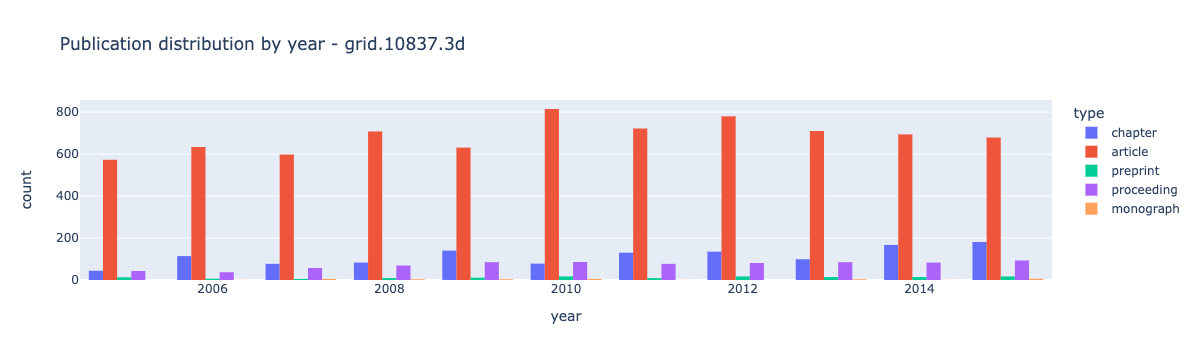

In [6]:
px.histogram(pubs, 
             x="year", 
             color="type", 
             barmode="group", 
             title=f"Publication distribution by year - {GRIDID}")

### What are the main subject areas? 

We can use the Field of Research categories information in publications to obtain a breakdown of the publications by subject areas. 

This can be achieved by 'exploding' the `category_for` data into a separate table, since there can be more than one category per publication. The new categories table also retains some basic info about the publications it relates to eg *journal*, *title*, *publication id* etc.. so to make it easier to analyse the data. 

In [7]:
pubs_categories = pubs.explode('category_for')
pubs_categories.dropna(subset=["category_for"], inplace=True)

def for_nice_name(for_dict):
    "transforms a category JSON into a nice looking title"
    if type(for_dict) == dict:
        name = for_dict['name']
        return ''.join([i for i in name if not i.isdigit()])
    else:
        return ""

# new col for nice name
pubs_categories["category_for_name"] = pubs_categories['category_for'].apply(lambda x: for_nice_name(x))
# new col for tot-pubs count
pubs_categories['count_pubs'] = pubs_categories.groupby("category_for_name")['id'].transform('count')

Let's view the top categories using a pie chart.

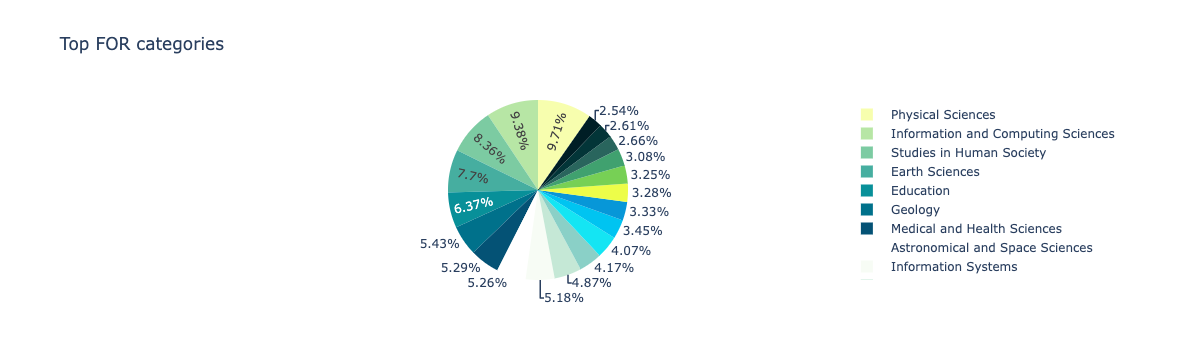

In [8]:
categories = pubs_categories.drop_duplicates(subset="category_for_name").sort_values("count_pubs", ascending=False)[['category_for_name', 'count_pubs']]

px.pie(categories[:20], 
       names="category_for_name", # the dimension for the slices
       values="count_pubs",  # the metric
       color_discrete_sequence=px.colors.sequential.Bluyl,
       title=f"Top FOR categories")

## 3. Extracting Patents linked to Publications

In this section we extract all patents linked to the publications dataset previously created. The steps are the following:

* we loop over the publication IDs and create patents queries, via the referencing `publication_ids` field of patents
* we collate all patens data, remove duplicates from patents and save the results 
* finally, we count patents per publication and enrich the original publication dataset with these numbers  

In [9]:
#
# the main patents query
#
q = """search patents 
        where publication_ids in {} 
      return patents[basics+publication_ids+category_for]"""

BATCHSIZE = 400
VERBOSE = False # set to True to see patents extraction logs


#
# loop through all pub IDs in chunks and query patents 
#
print("===\nExtracting patents data ...")
patents_json = []
pubsids = pubs['id']

for chunk in progressbar(list(chunks_of(list(pubsids), 400))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=VERBOSE)
    patents_json += data.patents
    time.sleep(1)
    

patents = pd.DataFrame().from_dict(patents_json)
patents.drop_duplicates(subset='id', inplace=True)
print("Patents found: ", len(patents))

===
Extracting patents data ...


  0%|          | 0/25 [00:00<?, ?it/s]

Patents found:  210


Let's preview the data

In [10]:
patents.head(5)

,assignee_names,assignees,category_for,filing_status,id,inventor_names,publication_date,publication_ids,times_cited,title,year,granted_year
0,"[UNIV OSAKA, NAKANO KENJI]","[{'city_name': 'Osaka', 'country_name': 'Japan...","[{'id': '2581', 'name': '0601 Biochemistry and...",Application,WO-2018139679-A1,"[NAKANO KENJI, CUI LIN, OBIKA SATOSHI, YAMAMOT...",2018-08-02,[pub.1050805130],2,NUCLEIC ACID DRUG CAPABLE OF INHIBITING INVASI...,2018,NaN
1,"[UNIV LIVERPOOL, UNIV HOSPITALS BRISTOL NHS FO...","[{'city_name': 'Bristol', 'country_name': 'Uni...","[{'id': '3142', 'name': '1112 Oncology and Car...",Application,WO-2019224542-A1,"[PROBERT CHRIS, BOND ASHLEY, GREENWOOD ROSEMARY]",2019-11-28,"[pub.1042614068, pub.1047923881, pub.102126644...",1,BIOMARKERS FOR COLORECTAL CANCER,2019,NaN
2,"[GENEURO SA, US HEALTH]",NaN,"[{'id': '3114', 'name': '1108 Medical Microbio...",Application,WO-2018136775-A1,"[PERRON HERVÉ, MEDINA JULIE, NATH AVINDRA, STE...",2018-07-26,"[pub.1001213892, pub.1028293805, pub.102276888...",0,ANTI-HERV-K ENVELOPE ANTIBODY AND USES THEREOF,2018,NaN
3,"[GENEURO SA, US HEALTH]",NaN,"[{'id': '3114', 'name': '1108 Medical Microbio...",Application,WO-2018136774-A1,"[PERRON HERVÉ, MEDINA JULIE, NATH AVINDRA, STE...",2018-07-26,"[pub.1001213892, pub.1028293805, pub.102276888...",0,ANTI-HERV-K ENVELOPE ANTIBODY AND USES THEREOF,2018,NaN
4,[Geneuro SA],NaN,"[{'id': '3114', 'name': '1108 Medical Microbio...",Application,EP-3351265-A1,"[PERRON HERVÉ, MEDINA JULIE]",2018-07-25,"[pub.1020608346, pub.1022768885, pub.106434678...",1,ANTI-HERV-K ENVELOPE ANTIBODY AND USES THEREOF,2017,NaN


### Enriching publications with patents citations metrics

Each patent record contains all the `publication_ids` it cites, so we can take this metric so to enrich the original publications dataset we created above. 

In [11]:
def count_patents_per_pub(pubid):
  global patents
  return len(patents[patents['publication_ids'].str.contains(pubid)])

# turn lists into strings to ensure compatibility with CSV loaded data
# see also: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
patents['publication_ids'] = patents['publication_ids'].apply(lambda x: ','.join(map(str, x))) 

progressbar.pandas()
pubs['patents'] = pubs['id'].progress_apply(lambda x: count_patents_per_pub(x))

  0%|          | 0/9751 [00:00<?, ?it/s]

Now the `patents` column gives us the top publications by number of citing patents

In [12]:
pubs.sort_values("patents", ascending=False).head()

,category_for,doi,id,research_orgs,researchers,times_cited,title,type,year,journal.id,journal.title,patents
9287,"[{'id': '3120', 'name': '1109 Neurosciences'},...",10.1096/fj.04-3458fje,pub.1002742563,"[{'city_name': 'Paris', 'country_name': 'Franc...","[{'first_name': 'Babette Barbash', 'id': 'ur.0...",972,Blood‐brain barrier‐specific properties of a h...,article,2005,jour.1017429,The FASEB Journal,24
3284,"[{'id': '3120', 'name': '1109 Neurosciences'},...",10.1096/fj.11-201384,pub.1033473743,"[{'acronym': 'CU', 'city_name': 'Ithaca', 'cou...","[{'first_name': 'Tengfei', 'id': 'ur.010276261...",116,Cell‐penetrating anti‐GFAP VHH and correspondi...,article,2012,jour.1017429,The FASEB Journal,16
3612,"[{'id': '2581', 'name': '0601 Biochemistry and...",10.1111/j.1474-9726.2012.00795.x,pub.1006294106,"[{'city_name': 'Newcastle upon Tyne', 'country...","[{'first_name': 'Glyn', 'id': 'ur.01064645067....",380,A senescent cell bystander effect: senescence-...,article,2012,jour.1030078,Aging Cell,15
5821,"[{'id': '2203', 'name': '03 Chemical Sciences'...",10.1021/bc900397s,pub.1055155906,"[{'city_name': 'Coventry', 'country_name': 'Un...","[{'first_name': 'Chiara', 'id': 'ur.0112461512...",41,Modification of Thiol Functionalized Aptamers ...,article,2009,jour.1100499,Bioconjugate Chemistry,9
9259,"[{'id': '2209', 'name': '09 Engineering'}, {'i...",10.1089/ten.2005.11.1611,pub.1059313359,"[{'acronym': 'UCL', 'city_name': 'London', 'co...","[{'first_name': 'James Benjamin', 'id': 'ur.07...",114,Neural Tissue Engineering: A Self-Organizing C...,article,2005,jour.1398624,Tissue Engineering,8


## 4. Patents Data Analysis

Now that we have extracted all the data we need, let's start exploring them by building a few visualizations. 

###  How many patents per year? 

In [13]:
px.histogram(patents, x="year", 
             color="filing_status", 
             barmode="group", 
             title=f"Patents referencing publications from {GRIDID} - by year")

### Who is filing the patents?

This can be done by looking at the field `assigness` of patent. Since the field contains nested information, first we need to extract it into its own table (similarly to what we've done above with publications categories). 

In [14]:
# ensure the key exists in all rows (even if empty) 
from dimcli.shortcuts import normalize_key
normalize_key('assignees', patents_json)
# explode assigness into separate table 
patents_assignees = pd.json_normalize(patents_json, 
                                   record_path=['assignees'], 
                                   meta=['id', 'year', 'title'], 
                                   meta_prefix="patent_", 
                                errors="ignore")
top_assignees = patents_assignees.groupby(['name', 'country_name'],  
                                          as_index=False).count().sort_values(by="patent_id", ascending=False)
# preview the data: ps the patent_id column is the COUNT of patents
top_assignees[['name', 'country_name', 'patent_id']].head()

,name,country_name,patent_id
24,French Institute of Health and Medical Research,France,18
25,French National Centre for Scientific Research,France,17
58,Pasteur Institute of Lille,France,13
88,University of Paris,France,7
98,Wisconsin Alumni Research Foundation,United States,7


In [15]:
px.bar(top_assignees, 
       x="name", y="patent_id", 
       hover_name="name", color="country_name",
       height=900,
       title=f"Top Assignees for patents referencing publications from {GRIDID}")

In [16]:
px.scatter(patents_assignees,  
           x="name", y="country_name", 
           color="patent_year", hover_name="name",  
           height = 1000,
           hover_data=["id", "patent_id"],  marginal_y="histogram",
           title=f"Assignees for patents referencing publications from {GRIDID} - Yearly breakdown")

### What are the publications most frequenlty referenced in patents?

In [17]:
pubs_cited = pubs.query("patents > 0 ").sort_values('patents', ascending=False).copy()
pubs_cited.head()

,category_for,doi,id,research_orgs,researchers,times_cited,title,type,year,journal.id,journal.title,patents
9287,"[{'id': '3120', 'name': '1109 Neurosciences'},...",10.1096/fj.04-3458fje,pub.1002742563,"[{'city_name': 'Paris', 'country_name': 'Franc...","[{'first_name': 'Babette Barbash', 'id': 'ur.0...",972,Blood‐brain barrier‐specific properties of a h...,article,2005,jour.1017429,The FASEB Journal,24
3284,"[{'id': '3120', 'name': '1109 Neurosciences'},...",10.1096/fj.11-201384,pub.1033473743,"[{'acronym': 'CU', 'city_name': 'Ithaca', 'cou...","[{'first_name': 'Tengfei', 'id': 'ur.010276261...",116,Cell‐penetrating anti‐GFAP VHH and correspondi...,article,2012,jour.1017429,The FASEB Journal,16
3612,"[{'id': '2581', 'name': '0601 Biochemistry and...",10.1111/j.1474-9726.2012.00795.x,pub.1006294106,"[{'city_name': 'Newcastle upon Tyne', 'country...","[{'first_name': 'Glyn', 'id': 'ur.01064645067....",380,A senescent cell bystander effect: senescence-...,article,2012,jour.1030078,Aging Cell,15
5821,"[{'id': '2203', 'name': '03 Chemical Sciences'...",10.1021/bc900397s,pub.1055155906,"[{'city_name': 'Coventry', 'country_name': 'Un...","[{'first_name': 'Chiara', 'id': 'ur.0112461512...",41,Modification of Thiol Functionalized Aptamers ...,article,2009,jour.1100499,Bioconjugate Chemistry,9
9259,"[{'id': '2209', 'name': '09 Engineering'}, {'i...",10.1089/ten.2005.11.1611,pub.1059313359,"[{'acronym': 'UCL', 'city_name': 'London', 'co...","[{'first_name': 'James Benjamin', 'id': 'ur.07...",114,Neural Tissue Engineering: A Self-Organizing C...,article,2005,jour.1398624,Tissue Engineering,8


In [18]:
px.bar(pubs_cited[:1000], 
       color="type",
       x="year", y="patents", 
       hover_name="title",  hover_data=["journal.title"],
       title=f"Top Publications from {GRIDID} mentioned in patents, by year of publication")

### What are the main subject areas of referenced publications?

In [19]:
THRESHOLD_PUBS = 1000
citedids = list(pubs_cited[:THRESHOLD_PUBS]['id'])
pubs_categories_cited = pubs_categories[pubs_categories['id'].isin(citedids)]

In [20]:
px.scatter(pubs_categories_cited, x="year", y="category_for_name", color="type", 
           hover_name="title", 
           hover_data=["doi", "year", "journal.title"],
           height=800,
           marginal_x="histogram", marginal_y="histogram", 
           title=f"Top {THRESHOLD_PUBS} {GRIDID} publications cited by patents - by subject area")

### Is there a correlation between publication citations and patents citations? 

Note: if the points on a scatterplot graph produce a lower-left-to-upper-right pattern (see below), that is indicative of a positive correlation between the two variables. This pattern means that when the score of one observation is high, we expect the score of the other observation to be high as well, and vice versa.

In [21]:
px.scatter(pubs, x="patents", y="times_cited", 
           title=f"Patents citations VS Publication citations")

---
## Where to go from here

In this [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) tutorial we have seen how, starting from a GRID organization, it is possible to extract a) publications from authors associated to this organization, b) patents citing those publications (from any organization). 

This only scratches the surface of the possible applications of publication-patents linkage data, but hopefully it'll give you a few basic tools to get started building your own application. Here are some ideas for customizing this notebook:

* Change the GRID ID to another one you are more familiar with
* Use a different way to select publications: e.g. not using an organizations segment, but a category, a country, a funder or a combination of the many [Publication filters](https://docs.dimensions.ai/dsl/datasource-publications.html) available
* Do a more in-depth analysis of the patents inventors: do they have other publications linking to the publications they cite in patents? Are there patterns of collaborations with the institutions they cite? 